In [96]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags, identity, kron, tril, triu
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import diags, tril, triu
from scipy.sparse.linalg import spsolve
import os

# Génère la matrice creuse du Laplacien 2D avec conditions de Dirichlet

In [42]:
def generate_poisson_2d_sparse(n):
    e = np.ones(n)
    T = diags([e, -4*e, e], [-1, 0, 1], shape=(n, n))
    I = identity(n)
    A = kron(I, T) + kron(diags([e, e], [-1, 1], shape=(n, n)), I)
    return A.tocsr()

# Préconditionneur Jacobi : inverse diagonal

In [45]:
def preconditioner_jacobi(A):
    M_diag = A.diagonal()
    M_diag[M_diag == 0] = 1e-10  # Empêche division par zéro
    def M_inv(r):
        return r / M_diag
    return M_inv


# Préconditionneur SSOR (approximatif)

In [48]:
def preconditioner_ssor(A, omega=1.0):
    """
    Préconditionneur SSOR : M^{-1} * r ≈ (D/ω + L)^{-1} * D * (D/ω + U)^{-1} * r
    """
    D = diags(A.diagonal())
    L = tril(A, -1)
    U = triu(A, 1)

    # Matrices pour SSOR : M1 = D/ω + L ; M2 = D/ω + U
    M1 = (1.0 / omega) * D + L
    M2 = (1.0 / omega) * D + U

    def M_inv(r):
        y = spsolve(M2, r)      # résolution M2 y = r
        z = D @ y               # multiplication par D
        x = spsolve(M1, z)      # résolution M1 x = z
        return x

    return M_inv


# Gradient conjugué

In [51]:

def gradient_conjugue(A, b, x0=None, tol=1e-8, max_iter=1000, M=None):
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()
    r = b - A @ x
    z = M(r) if M else r
    p = z.copy()
    rz_old = np.dot(r, z)
    errors = [np.linalg.norm(r)]
    start = time.time()

    for i in range(max_iter):
        Ap = A @ p
        denom = np.dot(p, Ap)
        if denom == 0 or np.isnan(denom) or np.isinf(denom):
            print(f"Arrêt à l’itération {i} : division par zéro ou valeur non définie")
            break
        alpha = rz_old / denom
        x += alpha * p
        r -= alpha * Ap
        error = np.linalg.norm(r)
        errors.append(error)
        if error < tol:
            break
        z = M(r) if M else r
        rz_new = np.dot(r, z)
        p = z + (rz_new / rz_old) * p
        rz_old = rz_new

    if len(errors) < 2:
        errors.append(errors[-1])

    end = time.time()
    return x, errors, i + 1, end - start


# Affichage d'une courbe

In [54]:
def plot_single_convergence(errors, label):
    plt.figure()
    plt.semilogy(errors, label=label)
    plt.xlabel("Itération")
    plt.ylabel("Erreur (log)")
    plt.title(f"Convergence : {label}")
    plt.grid(True)
    plt.legend()
    plt.show()

# Résolution sans préconditionneur

>> Résolution sans préconditionneur
Convergence en 208 itérations, temps = 0.04810s
Erreurs (début) : [100.0, 494.9747468305833, 484.888421505342, 499.03578271624167, 564.6743410779349]


<Figure size 1000x600 with 0 Axes>

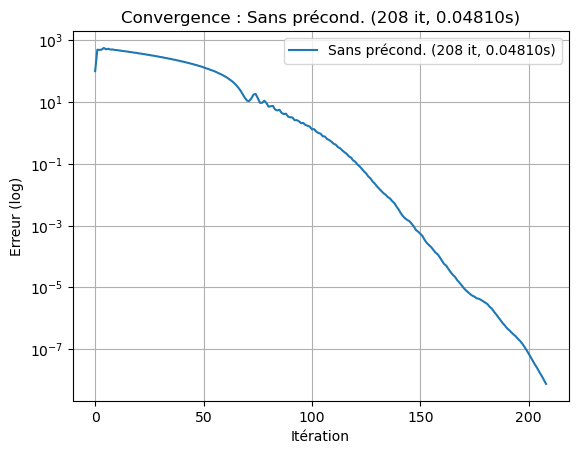

<Figure size 640x480 with 0 Axes>

In [108]:
if __name__ == "__main__":
    n = 100
    A = generate_poisson_2d_sparse(n)
    N = A.shape[0]
    b = np.ones(N)
    
    plt.figure(figsize=(10, 6))
    print(">> Résolution sans préconditionneur")
    x, errors, k, t = gradient_conjugue(A, b)
    print(f"Convergence en {k} itérations, temps = {t:.5f}s")
    print("Erreurs (début) :", errors[:5])
    plot_single_convergence(errors, f"Sans précond. ({k} it, {t:.5f}s)")
    plt.show()
    

# Résolution avec préconditionneur Jacobi

>> Résolution avec préconditionneur Jacobi
Convergence en 208 itérations, temps = 0.12632s
Erreurs (début) : [100.0, 494.9747468305833, 484.888421505342, 499.03578271624167, 564.6743410779349]


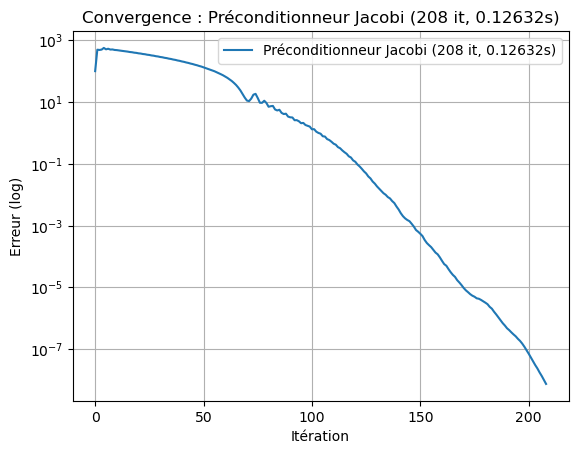

In [86]:
    print(">> Résolution avec préconditionneur Jacobi")
    M_jacobi = preconditioner_jacobi(A)
    xj, errors_j, kj, tj = gradient_conjugue(A, b, M=M_jacobi)
    print(f"Convergence en {kj} itérations, temps = {tj:.5f}s")
    print("Erreurs (début) :", errors_j[:5])
    plot_single_convergence(errors_j, f"Préconditionneur Jacobi ({kj} it, {tj:.5f}s)")

# Résolution avec préconditionneur SSOR

>> Résolution avec préconditionneur SSOR
Convergence en 108 itérations, temps = 2.47929s
Erreurs (début) : [100.0, 475.255031683342, 464.61671401305705, 435.03420263714617, 409.54081508213307]


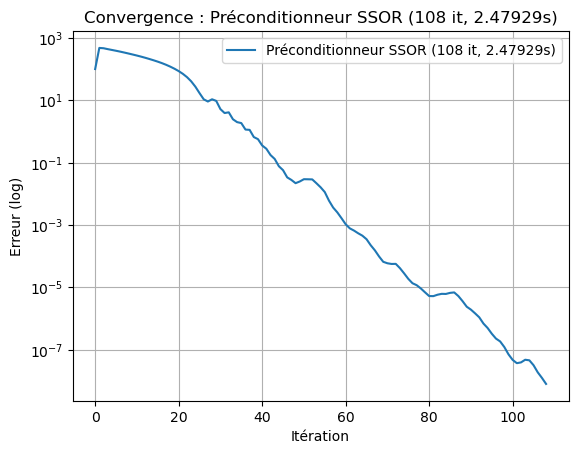

In [91]:
    print(">> Résolution avec préconditionneur SSOR")
    M_ssor = preconditioner_ssor(A, omega=1.0)
    xs, errors_s, ks, ts = gradient_conjugue(A, b, M=M_ssor)
    print(f"Convergence en {ks} itérations, temps = {ts:.5f}s")
    print("Erreurs (début) :", errors_s[:5])
    plot_single_convergence(errors_s, f"Préconditionneur SSOR ({ks} it, {ts:.5f}s)")

# Affichage des erreurs

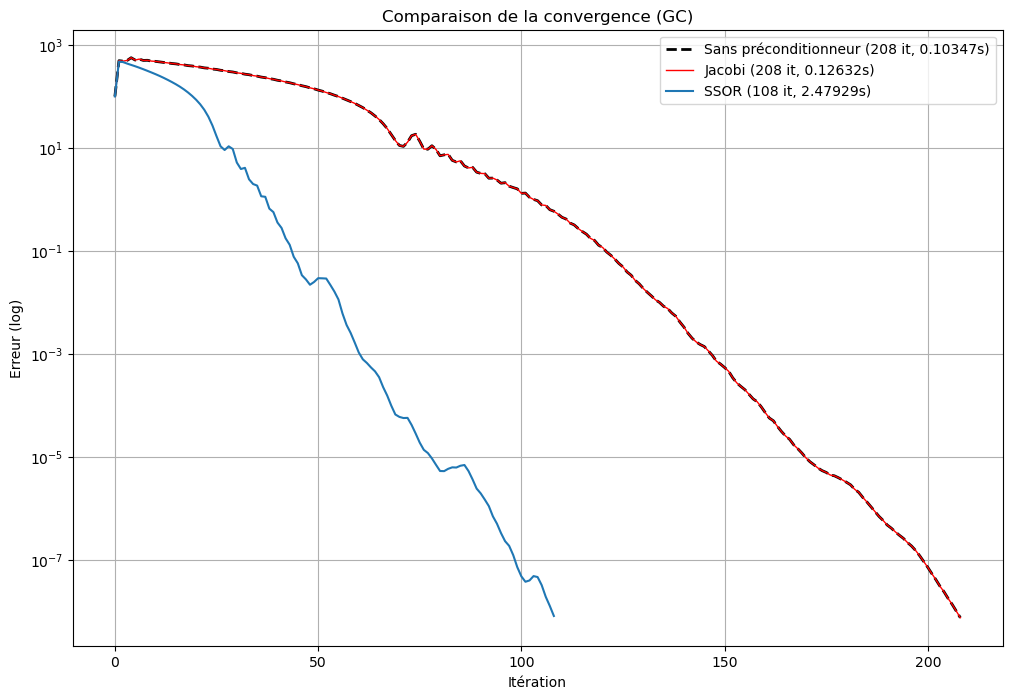

In [93]:
plt.figure(figsize=(12,8))
plt.semilogy(errors, label=f"Sans préconditionneur ({k} it, {t:.5f}s)", color="black", linestyle="--", linewidth=2)
plt.semilogy(errors_j, label=f"Jacobi ({kj} it, {tj:.5f}s)", color="red",linestyle="-", linewidth=1)
plt.semilogy(errors_s, label=f"SSOR ({ks} it, {ts:.5f}s)")
plt.xlabel("Itération")
plt.ylabel("Erreur (log)")
plt.title("Comparaison de la convergence (GC)")
plt.grid(True)
plt.legend()
plt.show()